# Correlaciones


###  A) ¿El nivel socioeconómico de una comuna (pobreza, ingresos) puede predecir su número de muertes por COVID-19?

Primero necesitamos modelar e identificar las variables involucradas para responder a la interrogante.

### 1. Preparar los datos

In [9]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [14]:
# Datos de muertes
path_muertes = 'Data/Covid-19/muertes_por_anio_comunal.csv' 
try:
    df_muertes = pd.read_csv(path_muertes)
    df_muertes_2021 = df_muertes[df_muertes['Año'] == 2021.0].copy()

    # Seleccionamos solo las columnas que necesitamos
    df_muertes_2021 = df_muertes_2021[['Comuna', 'Total fallecidos']]

    # Renombramos la columna para mayor claridad
    df_muertes_2021.rename(columns={'Total fallecidos': 'Muertes_2021'}, inplace=True)

    print("Datos de muertes 2021 listos.")
    print(df_muertes_2021.head())

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta: {path_muertes}")
    exit()


# Datos socioeconómicos
path_socio = 'Data/Nivel socioeconomico y geografico/Dataset_Socio_RM.csv'

try:
    df_socio_raw = pd.read_csv(path_socio, low_memory=False)
    
    df_socio_2021 = df_socio_raw[df_socio_raw['Año'] == 2021].copy()

    # (1 si es 'Pobreza Extrema' o 'Pobreza No Extrema', 0 si es 'No Pobreza')
    categorias_pobreza = ['Pobreza Extrema', 'Pobreza No Extrema']
    df_socio_2021['es_pobre'] = df_socio_2021['Pobreza Categoria'].apply(lambda x: 1 if x in categorias_pobreza else 0)
    # - INDICE_POBREZA: será el promedio (mean) de la columna 'es_pobre'
    # - INGRESO_PROMEDIO: será el promedio (mean) de 'Ingreso_hogar'
    df_socio_agg = df_socio_2021.groupby('Comuna').agg(
        INDICE_POBREZA=('es_pobre', 'mean'),
        INGRESO_PROMEDIO=('Ingreso_hogar', 'mean')
    ).reset_index()

    print("Datos socioeconómicos agregados por comuna para 2021 listos.")
    print(df_socio_agg.head())

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta: {path_socio}")
    exit()
except Exception as e:
    print(f"Error procesando el archivo socioeconómico: {e}")


Datos de muertes 2021 listos.
             Comuna  Muertes_2021
1             Alhué         541.0
5              Buin        8405.0
9   Calera De Tango        1573.0
13        Cerrillos        8491.0
17      Cerro Navia       21636.0
Datos socioeconómicos agregados por comuna para 2021 listos.
        Comuna  INDICE_POBREZA  INGRESO_PROMEDIO
0        Alhué        0.000000      1.163712e+06
1         Buin        0.104478      1.024474e+06
2    Cerrillos        0.100000      1.046512e+06
3  Cerro Navia        0.102740      9.880384e+05
4       Colina        0.162162      1.005093e+06


### 2. Unir los datasets y Limpieza

In [15]:

df_final = pd.merge(df_muertes_2021, df_socio_agg, on='Comuna', how='inner')
df_final.dropna(subset=['Muertes_2021', 'INDICE_POBREZA', 'INGRESO_PROMEDIO'], inplace=True)
print(f"Datos combinados listos. {df_final.shape[0]} comunas tienen datos completos.")
print(df_final.head())


Datos combinados listos. 46 comunas tienen datos completos.
        Comuna  Muertes_2021  INDICE_POBREZA  INGRESO_PROMEDIO
0        Alhué         541.0        0.000000      1.163712e+06
1         Buin        8405.0        0.104478      1.024474e+06
2    Cerrillos        8491.0        0.100000      1.046512e+06
3  Cerro Navia       21636.0        0.102740      9.880384e+05
4       Colina       10524.0        0.162162      1.005093e+06


### 3. Aplicar Regresion Lineal

Variable $Y$ (Dependiente): total_muertes_2021 (del archivo muertes_por_anio_comunal.csv).

Variables $X$ (Independientes): INDICE_POBREZA y INGRESO_PROMEDIO (del archivo Dataset_Socio_RM.csv).

Modelo:  $total\_muertes\_2021 = \beta_0 + \beta_1 \cdot INDICE\_POBREZA + \beta_2 \cdot INGRESO\_PROMEDIO + \epsilon$

In [18]:


if df_final.empty:
    print("No hay datos suficientes para ejecutar la regresión después de limpiar y unir.")
else:

    var_y = df_final['Muertes_2021']

    var_X = df_final[['INDICE_POBREZA', 'INGRESO_PROMEDIO']]
    
    # Añadir una constante (el intercepto, B0) al modelo
    var_X = sm.add_constant(var_X)
    
    # Crear el modelo OLS (Ordinary Least Squares)
    modelo = sm.OLS(var_y, var_X)
    
    # Entrenar (ajustar) el modelo
    resultados = modelo.fit()

    print(resultados.summary())


                            OLS Regression Results                            
Dep. Variable:           Muertes_2021   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.3115
Date:                Wed, 05 Nov 2025   Prob (F-statistic):              0.734
Time:                        22:33:46   Log-Likelihood:                -496.01
No. Observations:                  46   AIC:                             998.0
Df Residuals:                      43   BIC:                             1003.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1.922e+04   6322.715  

### 4. Visualizacion de la regresion

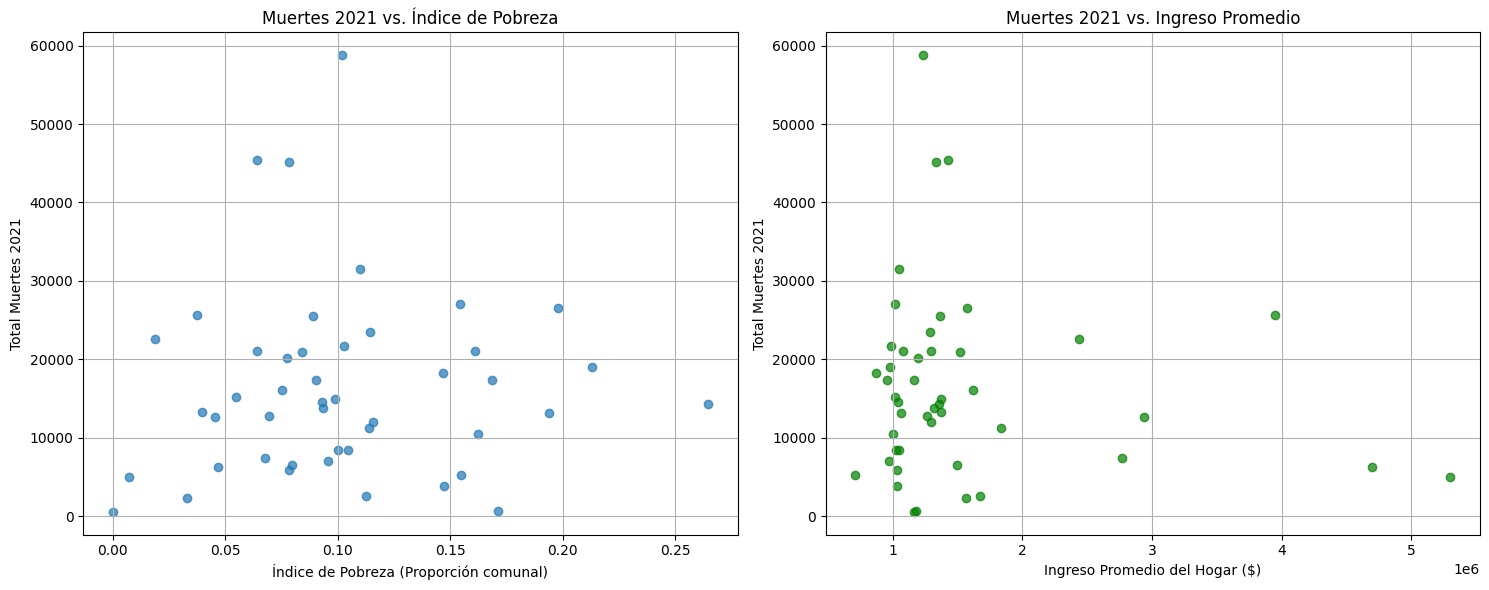

In [19]:

if not df_final.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Gráfico 1: Muertes vs. Pobreza
    ax1.scatter(df_final['INDICE_POBREZA'], df_final['Muertes_2021'], alpha=0.7)
    ax1.set_title('Muertes 2021 vs. Índice de Pobreza')
    ax1.set_xlabel('Índice de Pobreza (Proporción comunal)')
    ax1.set_ylabel('Total Muertes 2021')
    ax1.grid(True)

    # Gráfico 2: Muertes vs. Ingreso
    ax2.scatter(df_final['INGRESO_PROMEDIO'], df_final['Muertes_2021'], alpha=0.7, color='green')
    ax2.set_title('Muertes 2021 vs. Ingreso Promedio')
    ax2.set_xlabel('Ingreso Promedio del Hogar ($)')
    ax2.set_ylabel('Total Muertes 2021')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("No se pueden generar gráficos porque no hay datos.")